In [1]:
import tensorflow as tf
import keras
from keras import layers, models
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
def make_model(img_height, img_width):
    model = keras.Sequential([
            layers.Input((img_height,img_width,3)),
            layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
            layers.Conv2D(32, (3, 3), activation='relu',name='conv_1'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu',name='conv_2'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu',name='conv_3'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(3,activation='softmax')
        ])
    return model

In [3]:
base_model = make_model(256,256)
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv_1 (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv_2 (Conv2D)             (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv_3 (Conv2D)             (None, 60, 60, 64)        3

In [4]:
base_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [5]:
def load_data_tf(data_path: str, img_shape=(256,256), batch_size: int=64):
    train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        validation_split=0.2,
        subset="both",
        label_mode='categorical',
        seed=123,
        image_size=img_shape,
        batch_size=batch_size)
    return train_ds, val_ds

In [6]:
train_ds, val_ds = load_data_tf('cov_data')

Found 4575 files belonging to 3 classes.
Using 3660 files for training.
Using 915 files for validation.


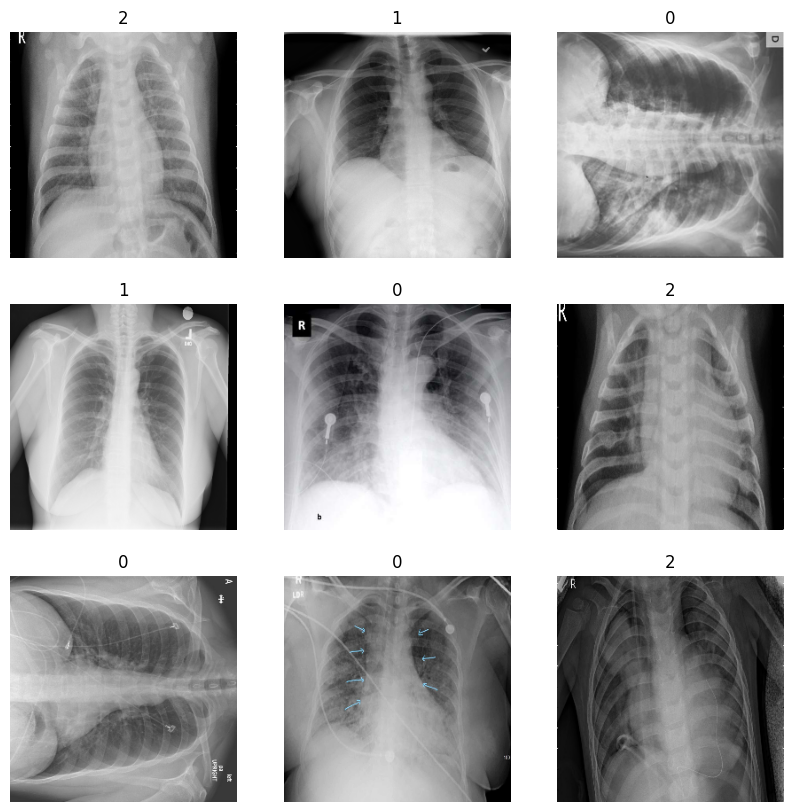

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(image_batch[i]).astype("uint8"))
        # print(label_batch[i])
        plt.title(np.argmax(label_batch[i]))
        plt.axis("off")

In [8]:
epochs=5
history = base_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=tf.keras.callbacks.EarlyStopping()
)

Epoch 1/5
58/58 [==============================] - 134s 2s/step - loss: 1.0565 - accuracy: 0.7383 - val_loss: 0.4874 - val_accuracy: 0.8022
Epoch 2/5
58/58 [==============================] - 133s 2s/step - loss: 0.3686 - accuracy: 0.8751 - val_loss: 0.3750 - val_accuracy: 0.8754
Epoch 3/5
58/58 [==============================] - 105s 2s/step - loss: 0.2729 - accuracy: 0.9104 - val_loss: 0.3624 - val_accuracy: 0.8798
Epoch 4/5
58/58 [==============================] - 100s 2s/step - loss: 0.2197 - accuracy: 0.9281 - val_loss: 0.3420 - val_accuracy: 0.8940
Epoch 5/5
58/58 [==============================] - 102s 2s/step - loss: 0.1821 - accuracy: 0.9391 - val_loss: 0.3720 - val_accuracy: 0.8995


In [18]:
# Code from TF

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    import matplotlib as mpl
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    from IPython.display import Image, display
    display(Image(cam_path))

Notice that in many cases the model only "pays attention" to the machine-produced labels: 

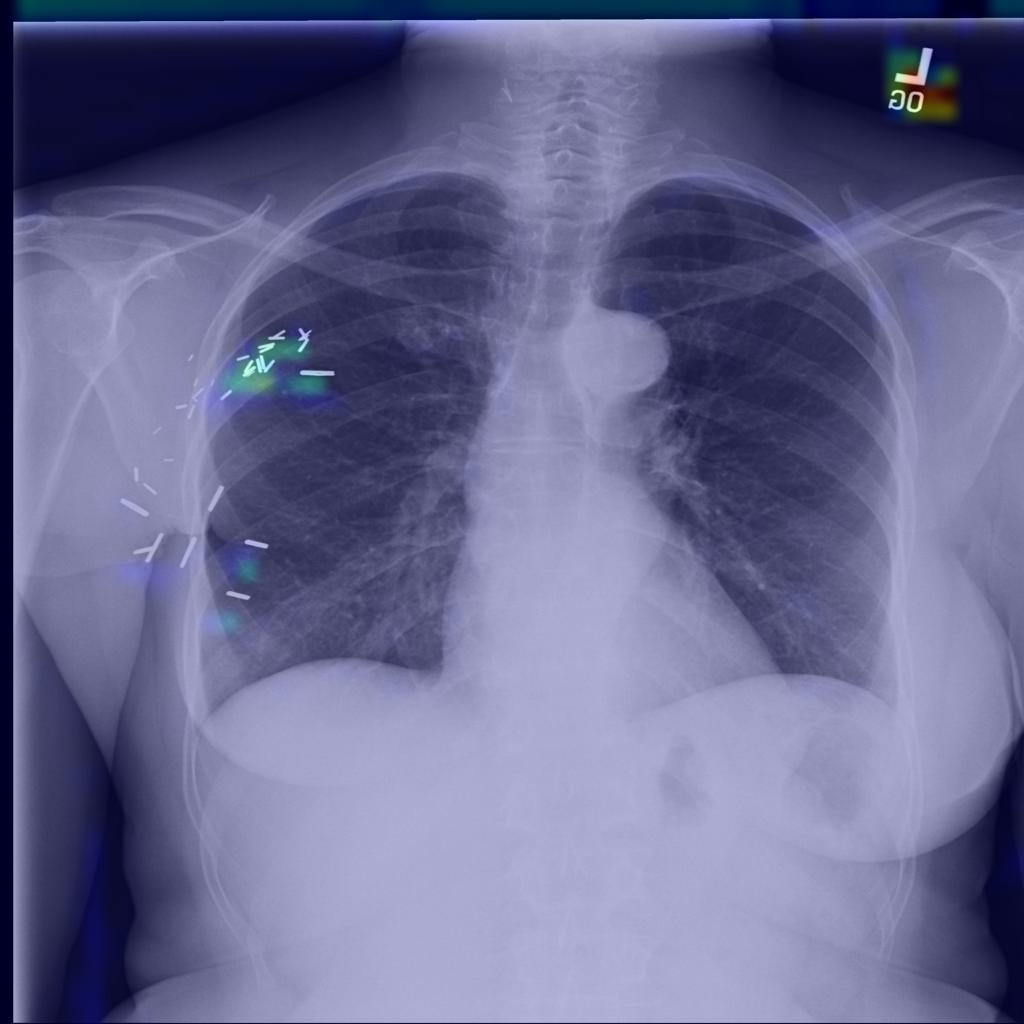

In [20]:
# path = 'cov_data\covid\COVID19(569).jpg'
path = 'cov_data/normal/00001059_008.png'
img = get_img_array(path, (256,256))
hmap = make_gradcam_heatmap(img, base_model, 'conv_3')
save_and_display_gradcam(path, hmap)